# Explore Fuse Pose Estimates
Stefan/Yuzhao Heng
Since Tues. Nov. 2nd, 2021

i.e. Get pose candidates from the HSR's laser scan in locating KUKA, and candidates from KUKA's laser scan in locating HSR.


## Setup



In [1]:
from icecream import ic

from scripts.util import *
from scripts.robo_pose_estimator import *


hsr_scans = json_load('../data/HSR laser 2.json')
s = hsr_scans[77]
scan_hsr = laser_polar2planar(s['angle_max'], s['angle_min'])(np.array(s['ranges']))


## A straightforward approach: ICP

### Setup

In [2]:
# Empirically have `robot_a` as HSR, `robot_b` as KUKA
pc_kuka = get_rect_pointcloud(
    PoseEstimator.L_KUKA,
    PoseEstimator.W_KUKA,
)
fp = PoseEstimator.FusePose(pc_b=pc_kuka)



### No guess whatsoever


In [3]:
Icp(pc_kuka, scan_hsr)(max_iter=100, min_d_err=1e-6)

# i.e. Identity transformation
title = 'HSR locates KUKA, default transform init'
# visualize(pc_kuka, scan_hsr, title)  # Jupyter's problem???? Shouldn't have shown an error



## An almost perfect guess
Only rotation is wrong, but the raw ICP output is not ideal



ic| tsf: array([[ 0.97433981, -0.22508207,  2.93116748],
                [ 0.22508207,  0.97433981, -0.78959615],
                [ 0.        ,  0.        ,  1.        ]])
    ori_tsl: array([ 2.93116748, -0.78959615])
    angle: 0.22702726469482437


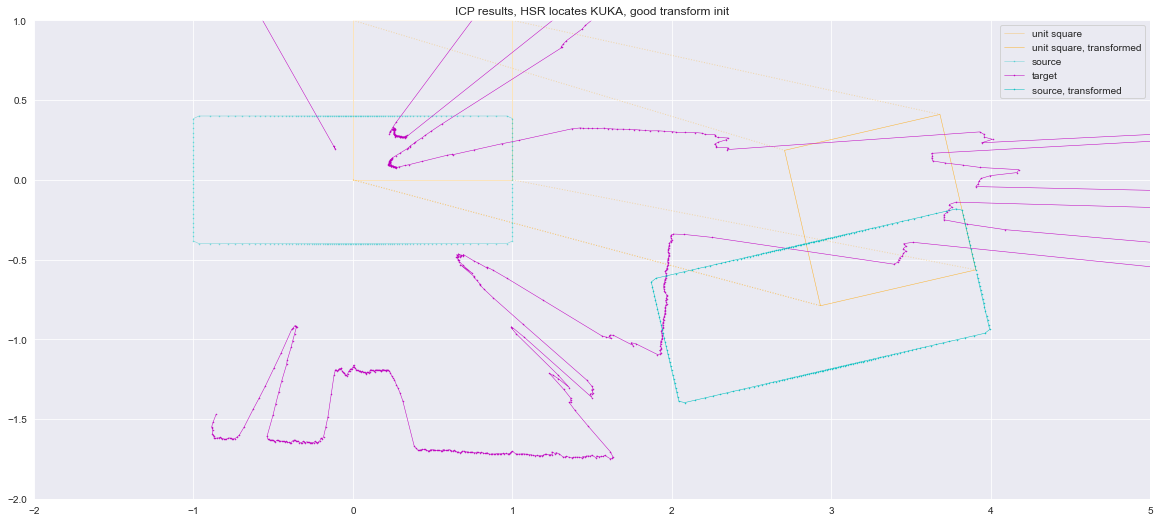

In [4]:
title = 'HSR locates KUKA, good transform init'
visualize(fp.pc_b, scan_hsr, tsf=np.array([
    [1, 0, 3],
    [0, 1, -0.5],
    [0, 0, 1]
]), title=title, xlim=[-2, 5], ylim=[-2, 1])


## Cluster the point clouds first
then run ICP on each, with the relative translation to cluster center


### Clustering
What algorithm work well? Ideally the number of clusters shouldn't be fixed.


#### Setup



In [5]:
c = Cluster.cluster

#### Spectral Clustering



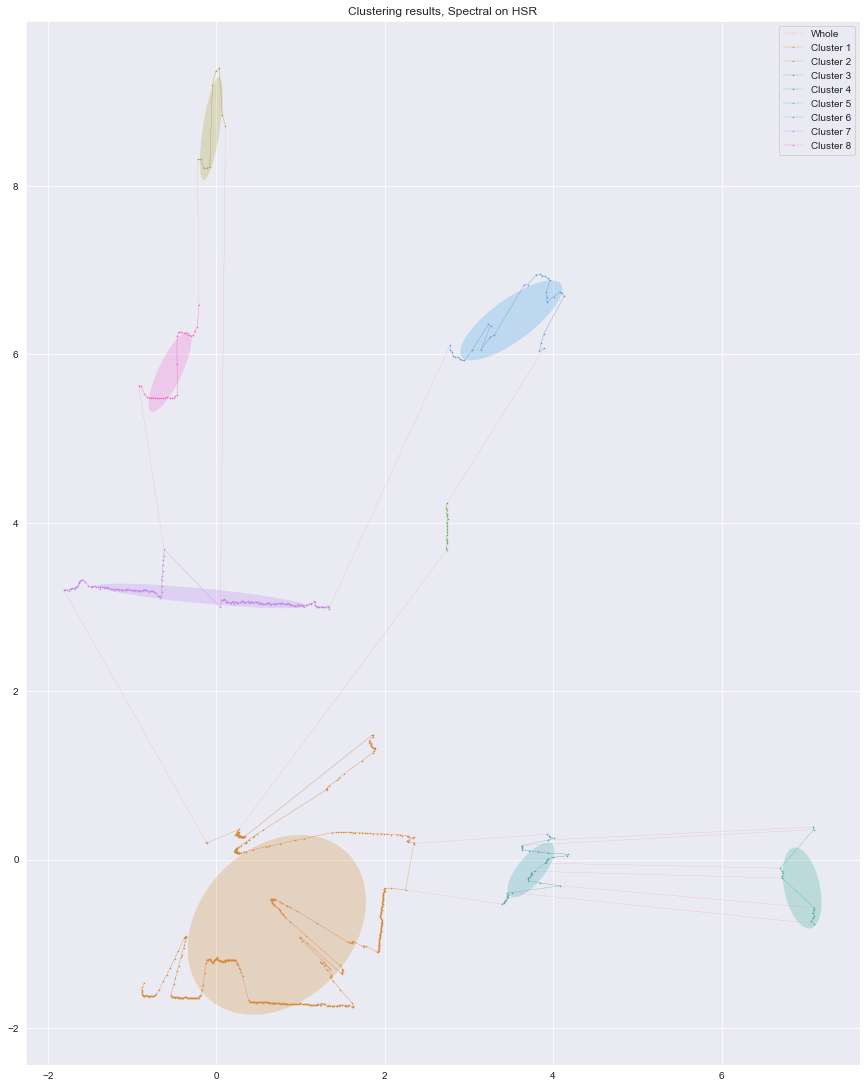

In [6]:
lbs = c(scan_hsr, approach='spectral', n_clusters=8)
plot_cluster(scan_hsr, lbs, title='Spectral on HSR')



#### Hierarchical Clustering



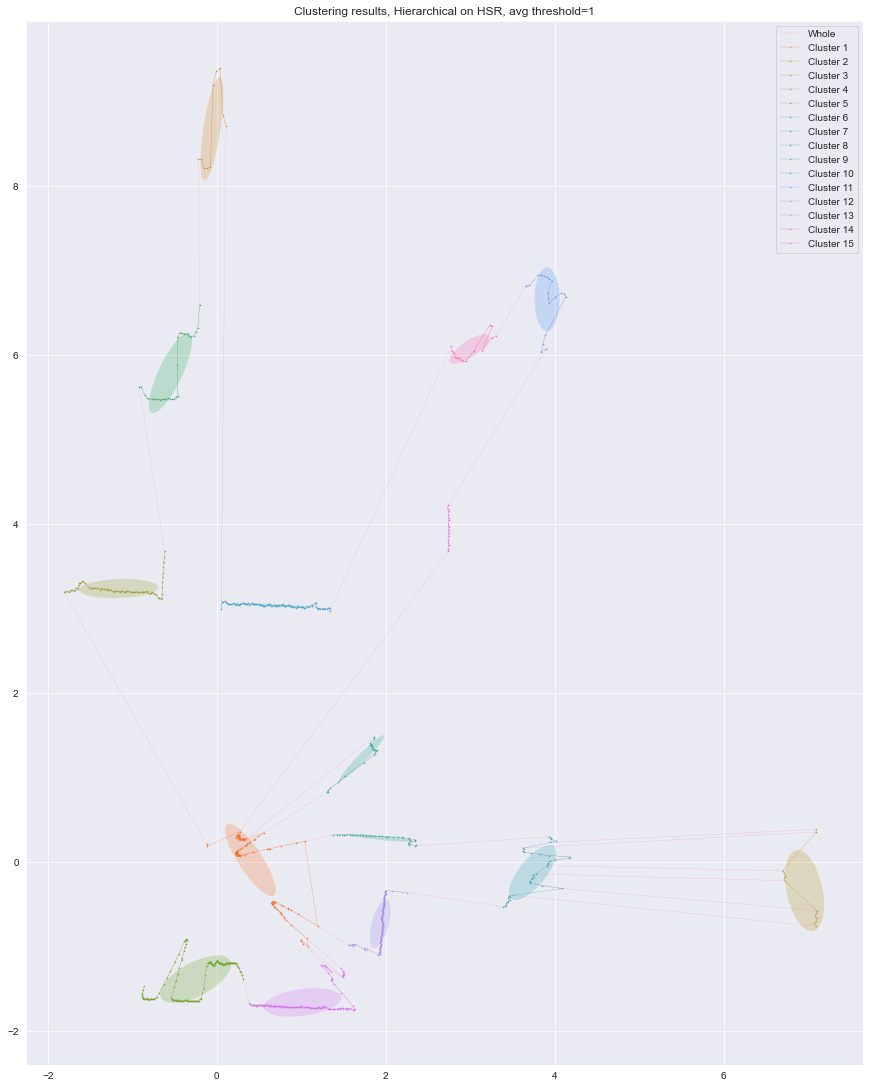

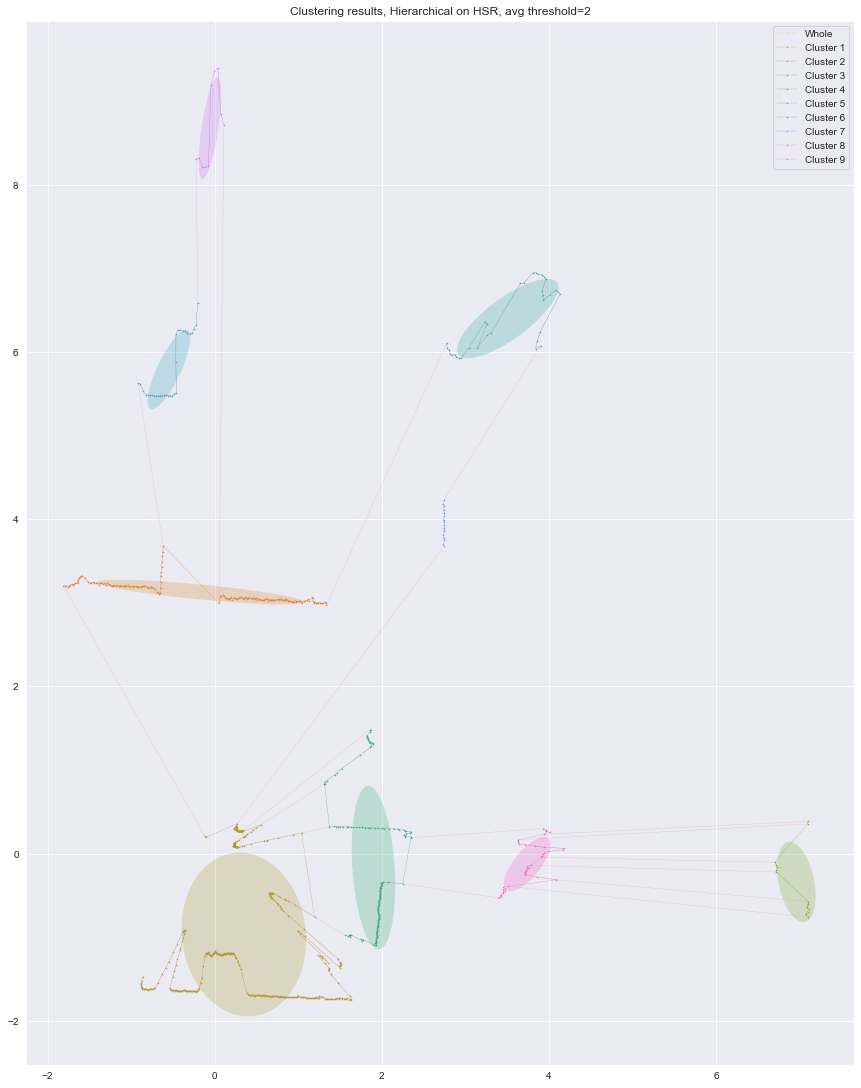

In [7]:
def _(d):
    lbs = c(scan_hsr, approach='hierarchical', distance_threshold=d)
    plot_cluster(scan_hsr, lbs, title=f'Hierarchical on HSR, avg threshold={d}')

_(1)
_(2)



#### Gaussian Mixture Model assignment



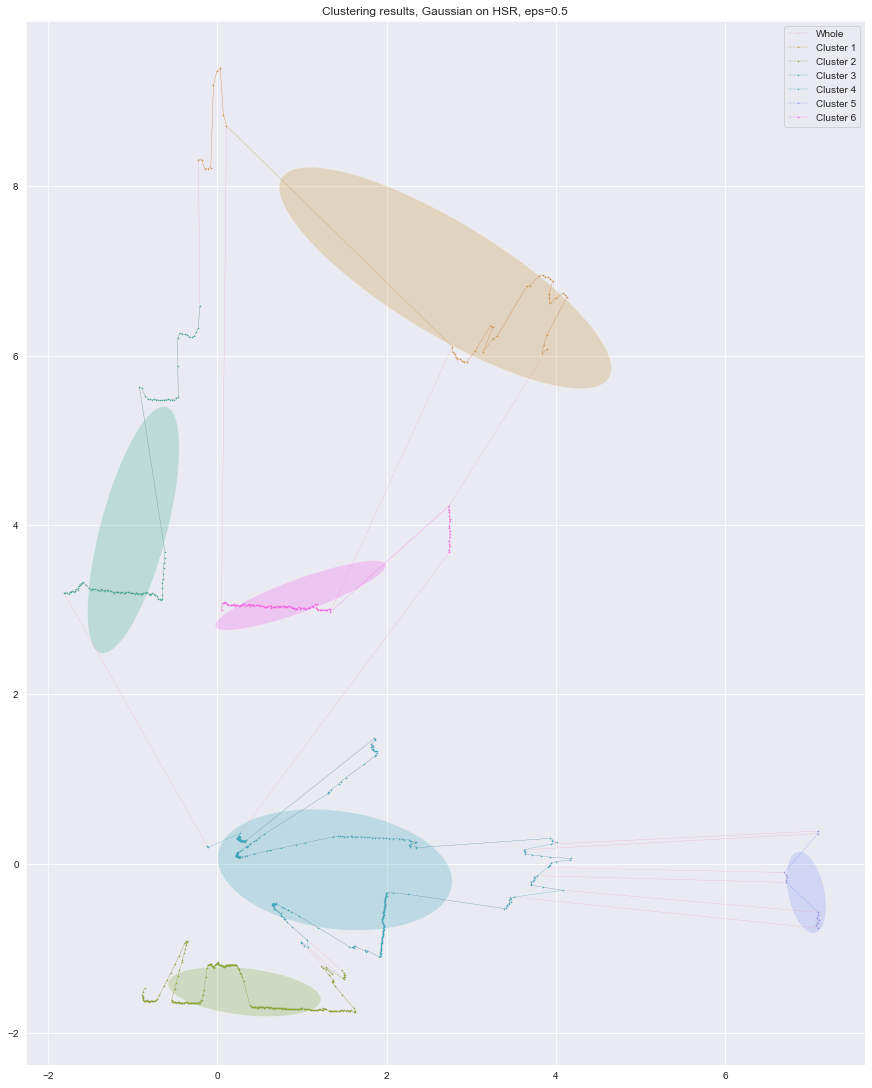

In [8]:
lbs = c(scan_hsr, approach='gaussian', n_components=6)
plot_cluster(scan_hsr, lbs, title='Gaussian on HSR, eps=0.5')



#### DBSCAN



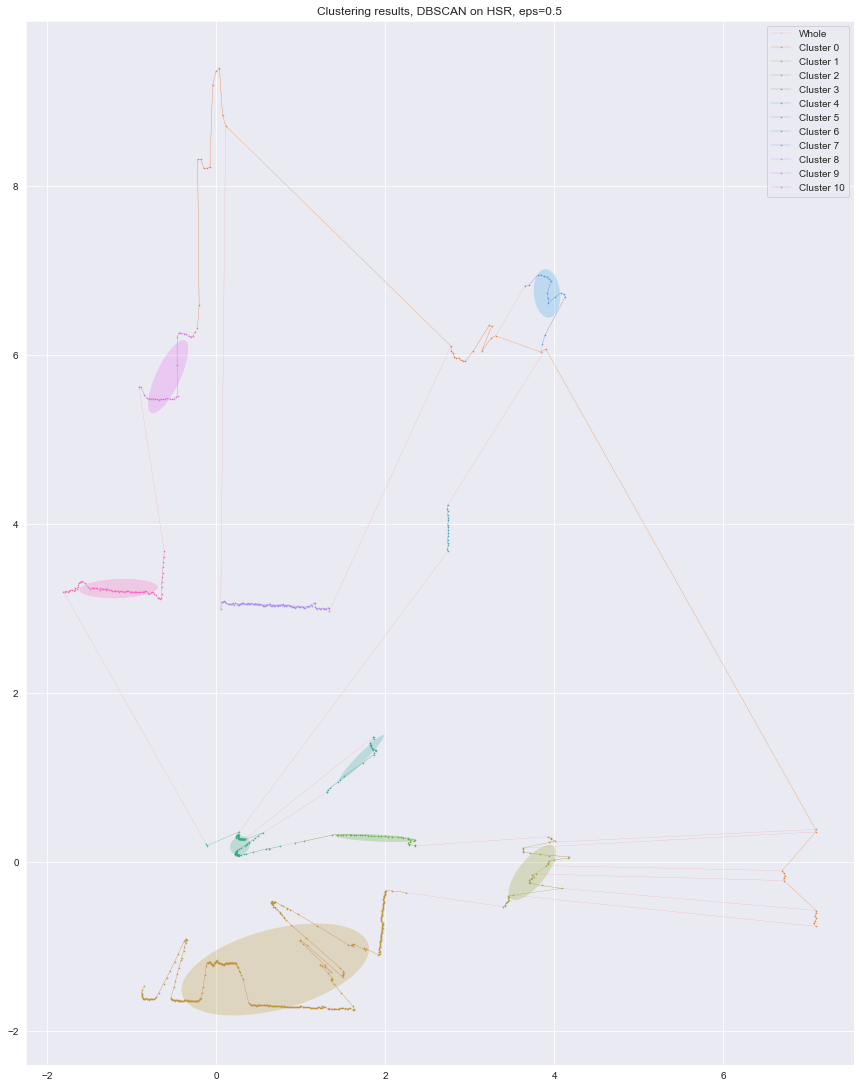

In [9]:
lbs = c(scan_hsr, approach='dbscan', eps=0.5, min_samples=16)
plot_cluster(scan_hsr, lbs, title='DBSCAN on HSR, eps=0.5')


### ICP with cluster translation initialisation


ic| tsf: array([[ 1.        ,  0.        , -0.05767092],
                [ 0.        ,  1.        ,  8.67903557],
                [ 0.        ,  0.        ,  1.        ]])
ic| tsf: array([[ 9.70124661e-01, -2.42606972e-01,  1.11519623e+27],
                [-2.42606972e-01, -9.70124661e-01,  9.05611070e+27],
                [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    ori_tsl: array([1.11519623e+27, 9.05611070e+27])
    angle: 0.24505220649678866


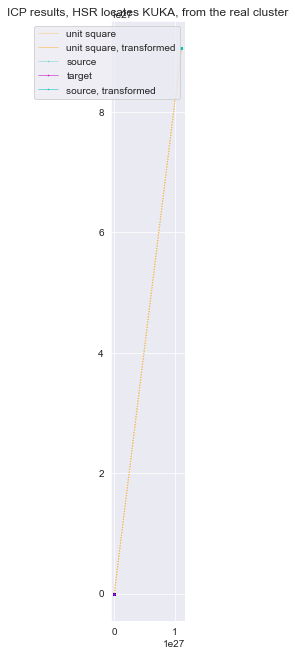

In [10]:
lbs = c(scan_hsr, approach='hierarchical', distance_threshold=1)   # A good clustering result by empirical inspection
d_clusters = {lb: scan_hsr[np.where(lbs == lb)] for lb in np.unique(lbs)}

cls = d_clusters[1]  # The cluster indicating real location of KUKA

title = 'HSR locates KUKA, from the real cluster'
tsf = np.identity(3)
tsf[:2, -1] = cls.mean(axis=0)
ic(tsf)
visualize(pc_kuka, scan_hsr, title=title, tsf=tsf)

